# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control2, decentralized.dynamics2, decentralized.cost2

In [2]:
import functools
import itertools
import random
from time import perf_counter as pc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation
import torch

from decentralized import control2, dynamics2, cost2, compute_pairwise_distance, split_agents
import pocketknives

π = np.pi

In [3]:
%matplotlib widget
plt.rcParams['axes.grid'] = True

In [6]:
def pos_mask(x_dims):
    """Return a mask that's true wherever there's an x or y position""" 
    return np.array([i % x_dims[0] < 2 for i in range(sum(x_dims))])

In [7]:
def plot_solve(X, J, x_goal, x_dims=None):
    """Plot the resultant trajectory on plt.gcf()"""

    plt.clf()
    
    if not x_dims:
        x_dims = [X.shape[1]]
        
    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_agents(X, x_dims)
    x_goal_split = split_agents(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        plt.scatter(Xi[:,0], Xi[:,1], c=t)
        plt.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
        plt.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")

## single-agent problem

In [8]:
def reference_cost(x, u, _x_goal, _Q, _R, _Qf=None, terminal=False):
    """Cost of reaching the goal"""
    
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)
    x = x.reshape(-1,1)
    u = u.reshape(-1,1)
    
    if _Qf is None:
        _Qf = torch.eye(_Q.shape[0])
    
    if terminal:
        return (x - _x_goal).T @ _Qf @ (x - _x_goal)
    return (x - _x_goal).T @ _Q @ (x - _x_goal) + u.T @ _R @ u

In [9]:
class UnicycleDynamics(dynamics2.AutodiffModel):
    @staticmethod
    def f(x, u):
        return torch.stack([
            x[3] * torch.cos(x[2]),
            x[3] * torch.sin(x[2]),
            u[0],
            u[1]
        ])

/home/zjw/documents/grad/Research/decentralized/decentralized/cost2.py:88: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755883846/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  return (x - self.xf) @ self.Q @ (x - self.xf).T + u @ self.R @ u.T


0/50	J: 210000
1/50	J: 106521	μ: 0.5	Δ: 0.5
2/50	J: 7777.31	μ: 0.125	Δ: 0.25
3/50	J: 4623.32	μ: 0.015625	Δ: 0.125
4/50	J: 3518.16	μ: 0.000976562	Δ: 0.0625
5/50	J: 3249.35	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3187.49	μ: 0	Δ: 0.015625
7/50	J: 3124.95	μ: 0	Δ: 0.0078125
8/50	J: 3094.62	μ: 0	Δ: 0.00390625
9/50	J: 3081.12	μ: 0	Δ: 0.00195312
10/50	J: 3074.96	μ: 0	Δ: 0.000976562


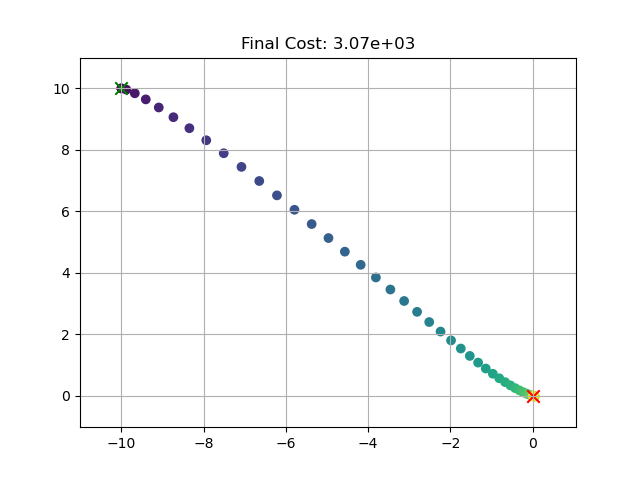

In [10]:
dt = 0.1
N = 50

x = torch.tensor([-10, 10, 0, 0], dtype=torch.float, requires_grad=True)
x_goal = torch.zeros((4, 1), dtype=torch.float)

dynamics = UnicycleDynamics(4, 2, dt)

Q = torch.diag(torch.tensor([1., 1, 0, 0]))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(2)
cost = cost2.ReferenceCost(x_goal, Q, R, Qf)

ilqr = control2.iLQR(dynamics, cost, x.numel(), 2, dt, N)
X, U, J = ilqr.solve(x)
plot_solve(X, J, x_goal.numpy())

## multi-agent problem

In [37]:
def dynamics_nd(f, x, u, _x_dims, _u_dims):
    """Compute the continuous time derivative for n agents"""
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)
    return torch.cat([
        f(xi.flatten(), ui.flatten()) 
        for xi, ui in zip(split_agents(x, _x_dims), split_agents(u, _u_dims))
    ])

In [11]:
def proximity_cost(X, _compute_pairwise_distance, _x_dims, _radius):
    """Penalizes distances underneath some radius between agents"""
    
    distances = _compute_pairwise_distance(X, _x_dims)
    pair_costs = torch.fmin(torch.zeros((1)), distances - _radius)**2
    return pair_costs.sum(dim=0)

In [12]:
def multi_agent_cost(goal_cost, prox_cost, x, u, terminal=False):
    """Reference deviation costs plus collision avoidance costs"""
    return goal_cost(x, u, terminal=terminal) + 100*prox_cost(x)

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [13]:
def randomize_locs(n_pts, min_sep=3.0, var=3.0, n_dim=2):
    """Uniformly randomize locations of points in N-D while enforcing
       a minimum separation between them.
    """ 
    
    # Distance to move away from center if we're too close.
    Δ = 0.1 * n_pts
    x = var * np.random.uniform(-1, 1, (n_pts, n_dim))
    
    # Determine the pair-wise indicies for an arbitrary number of agents.
    pair_inds = np.array(list(itertools.combinations(range(n_pts), 2)))
    move_inds = np.arange(n_pts)

    # Keep moving points away from center until we satisfy radius
    while move_inds.size:
        center = np.mean(x, axis=0)
        distances = compute_pairwise_distance(x.flatten(), [n_dim]*n_pts)

        move_inds = pair_inds[distances.flatten() <= min_sep]
        x[move_inds] += Δ * (x[move_inds] - center)
    
    return x

In [14]:
def face_goal(x0, x_goal):
    """Make the agents face the direction of their goal with a little noise"""
    
    VAR = 0.01
    dX = x_goal[:,:2] - x0[:,:2]
    headings = np.arctan2(*np.rot90(dX, 1))
    
    x0[:,2] = headings + VAR * np.random.randn(x0.shape[0])
    x_goal[:,2] = headings + VAR * np.random.randn(x0.shape[0])
    
    return x0, x_goal

In [15]:
def randy_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = torch.tensor([[0.5, 1.5, 0.1, 0,
                        2.5, 1.5, π, 0,
                        1.5, 1.3, π/2, 0]], 
                     dtype=torch.float, requires_grad=True).T
    x_goal = torch.tensor([[2.5, 1.5, 0, 0, 
                            0.5, 1.5, π, 0, 
                            1.5, 2.2, π/2, 0]]).T
    return x0, x_goal

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

In [16]:
def compute_energy(x, x_dims):
    """Determine the sum of distances from the origin"""
    return torch.sum(x[pos_mask(x_dims)].reshape(-1,2).norm(dim=1)).item()

def normalize_energy(x, x_dims, energy=10.0):
    """Zero-center the coordinates and then ensure the sum of 
       squared distances == energy
    """
    
    # Don't mutate x's data for this function, keep it pure.
    x = x.clone()
    n_agents = len(x_dims)
    center = x[pos_mask(x_dims)].reshape(-1, 2).mean(0)

    with torch.no_grad():
        x[pos_mask(x_dims)] -= center.tile(n_agents).reshape(-1,1)
        x[pos_mask(x_dims)] *= energy / compute_energy(x, x_dims)
    assert x.numel() == sum(x_dims)
    
    return x

def perturb_state(x, x_dims, var=0.5):
    """Add a little noise to the start to knock off perfect symmetries"""
    
    x = x.clone()
    with torch.no_grad():
        x[pos_mask(x_dims)] += var*torch.randn_like(x[pos_mask(x_dims)])
    
    return x

In [17]:
def random_setup(n_agents, **kwargs):
    """Create a randomized set up of initial and final positions"""
    
    # Rotate the initial points by some amount about the center.
    theta = π + random.uniform(-π/4, π/4)
    R = Rotation.from_euler('z', theta).as_matrix()[:2, :2]

    # We don't have to normlize for energy here
    x_i = randomize_locs(n_agents, **kwargs)
    x_f = x_i @ R + x_i.mean(axis=0)
    # x_f = randomize_locs(n_agents, 3.0)

    x0 = np.c_[x_i, np.zeros((n_agents, 2))]
    x_goal = np.c_[x_f, np.zeros((n_agents, 2))]
    x0, x_goal = face_goal(x0, x_goal)
    
    x0 = torch.from_numpy(x0).requires_grad_(True).type(torch.float)
    x_goal = torch.from_numpy(x_goal).type(torch.float)
    
    return x0.reshape(-1,1), x_goal.reshape(-1,1)

<Figure size 640x480 with 0 Axes>

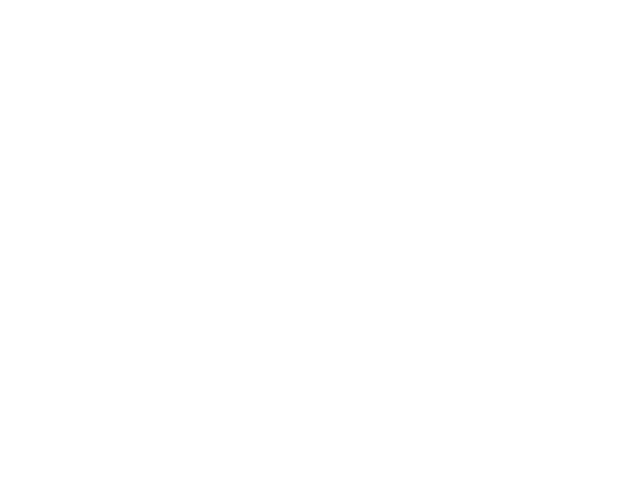

In [18]:
plt.figure()

In [19]:
n_agents = 3
sep_init = 1.0
# x0, x_goal = random_setup(n_agents, min_sep=sep_init, var=1.0)
x0, x_goal = randy_setup()

x_dims = [4] * n_agents
u_dims = [2] * n_agents
x0 = normalize_energy(x0, x_dims)
x_goal = normalize_energy(x_goal, x_dims)

# x0 = perturb_state(x0, x_dims)

plt.clf()
plt.gca().set_aspect('equal')
X = torch.dstack([
    x0.reshape(n_agents, 4).detach(), 
    x_goal.reshape(n_agents, 4).detach()
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[2*i]))
pocketknives.set_bounds(X.reshape(-1,4), zoom=0.2)

In [34]:
dt = 0.05
N = 50
tol = 1e-3

dynamics_12d = dynamics2.MultiDynamicalModel([UnicycleDynamics(4, 2, dt)] * n_agents)

Q = 4 * torch.diag(torch.tensor([1., 1, 0, 0]).tile(n_agents))
# Qf = 1000 * torch.eye(Q.shape[0])
Qf = 1000 * torch.diag(torch.tensor([1., 1, 0, 1]).tile(n_agents))
R = torch.eye(2*n_agents)

radius = 1.0

goal_cost = cost2.ReferenceCost(x_goal, Q, R, Qf)
prox_cost = cost2.ProximityCost(x_dims, radius)
game_cost = cost2.GameCost(goal_cost, prox_cost)

In [36]:
%%time
# %%prun
ilqr = control2.iLQR(dynamics_12d, game_cost, x0.numel(), 2*n_agents, dt, N)
t0 = pc()
X, U, J = ilqr.solve(x0, tol=tol)

# t_solve = pc() - t0
# with open('out.log', 'a') as file:
#     file.write(f"{type(ilqr)}\t{t_solve=:.8g}\t{J=:.8g}\n")

0/50	J: 190412
1/50	J: 20469.6	μ: 0.5	Δ: 0.5
2/50	J: 14191	μ: 0.125	Δ: 0.25
3/50	J: 14145.5	μ: 0.015625	Δ: 0.125
4/50	J: 14003.4	μ: 0.000976562	Δ: 0.0625
5/50	J: 13904.2	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 13828.9	μ: 0	Δ: 0.015625
CPU times: user 6.29 s, sys: 42 ms, total: 6.33 s
Wall time: 6.32 s


In [37]:
plot_solve(X, J, x_goal.numpy(), x_dims)

In [162]:
plt.clf()
plt.plot(compute_pairwise_distance(X, x_dims).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')

In [151]:
costs = []
for xi, ui in zip(X, U):
    costs.append(multi_cost(torch.from_numpy(xi), torch.from_numpy(ui)).item())
plt.clf()
plt.plot(costs)

In [152]:
def setup(X, x_goal, x_dims, radius):
    plt.clf()
    
    n_agents = len(x_dims)
    ax = plt.gca()
    handles = []
    for i in range(n_agents):
        handles.append((
            plt.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2))
        ))
        
    for xg in split_agents(x_goal, x_dims):
        plt.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, zoom=0.3)
    
    return handles
    
def animate(t, handles, X, x_dims, x_goal):
    """Animate the solution into a gif"""
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
    

In [153]:
plt.clf()
handles = setup(X, x_goal.flatten(), x_dims, radius)
animate(-1, handles, X, x_dims, x_goal)

In [106]:
handles = setup(X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(plt.gcf(), animate, frames=N+1, fargs=(handles, X, x_dims, x_goal))
anim.save('traj.gif', fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.
